In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import pandas as pd
import csv
import random
from imgaug import augmenters as iaa
import nibabel as nib
from glob import glob

Task:  Task01_BrainTumour
num_train = 484, num_test = 266
Image dimensions:
Train:
(240, 240, 155, 4)
(240, 240, 155, 4)
(240, 240, 155, 4)
(240, 240, 155, 4)
(240, 240, 155, 4)
Test:
(240, 240, 155, 4)
(240, 240, 155, 4)
(240, 240, 155, 4)
(240, 240, 155, 4)
(240, 240, 155, 4)
Image Min-Max values: Image=2646.0,0.0 and label=3.0,0.0
Number of subclasses =  4


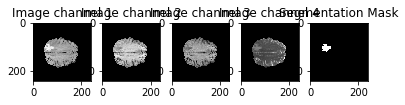

In [2]:
data_path = '/mnt/serverhdd1/jaehyub/project/'
tasks = [x for x in os.listdir(data_path) if x.startswith('Task')]

for task in tasks:
    print('Task: ', task)
    
    # Paths
    path_tr = data_path+task+'/imagesTr'
    path_tr_label = data_path+task+'/labelsTr'
    path_ts = data_path+task+'/imagesTs'
    imglist_tr = glob(path_tr+'/*.gz')
    imglist_tr_label = glob(path_tr_label+'/*.gz')
    imglist_ts = glob(path_ts+'/*.gz')
    print('num_train = {}, num_test = {}'.format(len(imglist_tr), len(imglist_ts)))
    print('Image dimensions:')
    print('Train:')
    
    # Dimensions
    for img_name in imglist_tr[:5]:
        img = nib.load(img_name)
        print(img.shape)
    print('Test:')
    for img_name in imglist_ts[:5]:
        img = nib.load(img_name)
        print(img.shape)
    
    # Find number of sub labels
    
    # Images
    img = nib.load(imglist_tr[70]).get_fdata()
    label = nib.load(imglist_tr_label[70]).get_fdata()
    print('Image Min-Max values: Image={},{} and label={},{}'.format(img.max(), img.min(), label.max(), label.min()))
    print('Number of subclasses = ', int(label.max())+1)
    if True:
        ax = plt.subplot('151')
        ax.imshow(img[:,:,100,0], cmap='gray')
        ax.set_title('Image channel 1')
        ax = plt.subplot('152')
        ax.imshow(img[:,:,100,1], cmap='gray')
        ax.set_title('Image channel 2')
        ax = plt.subplot('153')
        ax.imshow(img[:,:,100,2], cmap='gray')
        ax.set_title('Image channel 3')
        ax = plt.subplot('154')
        ax.imshow(img[:,:,100,3], cmap='gray')
        ax.set_title('Image channel 4')
        ax = plt.subplot('155')
        ax.imshow(label[:,:,100], cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()
    else:
        ax = plt.subplot('121')
        ax.imshow(img[:,:,10], cmap='gray')
        ax.set_title('Input image')
        ax = plt.subplot('122')
        ax.imshow(label[:,:,10], cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()
        print('\n')

In [3]:
os.chdir('Mask_RCNN')

In [4]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log    

Using TensorFlow backend.


In [5]:
train_dicom_dir = path_tr
test_dicom_dir = path_ts

In [6]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob(dicom_dir+'/'+'*.gz')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId'])
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [7]:
image_fps_train = imglist_tr
image_fps_test= imglist_ts

In [8]:
anns = pd.read_csv('/mnt/serverhdd1/jaehyub/project/label_encoding_1024_all.csv')
print(anns[:3])

            ImageId                                      EncodedPixels
0  BRATS_031.nii.gz  619122 17 620146 17 621170 17 622194 17 623210...
1  BRATS_467.nii.gz  557537 4 558561 4 559585 4 560609 4 561624 22 ...
2  BRATS_006.nii.gz  426341 26 427365 26 428389 26 429413 26 430424...


In [9]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    NAME = 'braintumour'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  
    
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    RPN_ANCHOR_SCALES = (8,16,32,64,128)
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [10]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).transpose()  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [11]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()

In [12]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob(dicom_dir+'/'+'*.gz')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['ImageId'])
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [13]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
image_fps_val = imglist_ts
image_fps_train = imglist_tr

print(len(image_fps))

484


In [14]:
ORIG_SIZE = 1024

In [15]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('braintumour', 1, 'braintumour')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('braintumour', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        img = nib.load(str(fp)).get_fdata()
        img = img[:,:,100]
        img = img[:,:,:3]
        img=cv2.resize(img, (1024,1024))
        img = img/img.max()*255
        img = img.astype(np.uint8)
        return img

    def load_mask(self, image_id):
        info = self.image_info[image_id]
       # print('info = ',info)  #####################
        annotations = info['annotations']
        #print('annotation = ',annotations)#############
        count = len(annotations)
        mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
        class_ids = np.zeros((count,), dtype=np.int32)
        for i, a in enumerate(annotations):
            if str(a.EncodedPixels) == 'nan':
                mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
                class_ids = np.zeros((count,), dtype=np.int32)
                break
            mask[:, :, i] = rle_decode(a.EncodedPixels,(1024,1024))
            class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [16]:
#image_fps, image_annotations = train_names, anns

In [17]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [18]:
dataset_val = DetectorDataset(image_fps_train[:50], image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

end (1024, 1024, 1) [1]
(1024, 1024, 3)


(-0.5, 1023.5, 1023.5, -0.5)

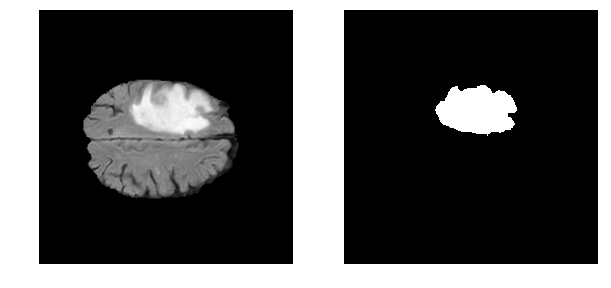

In [19]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('end',mask.shape,class_ids)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')


In [20]:
image.max()

255

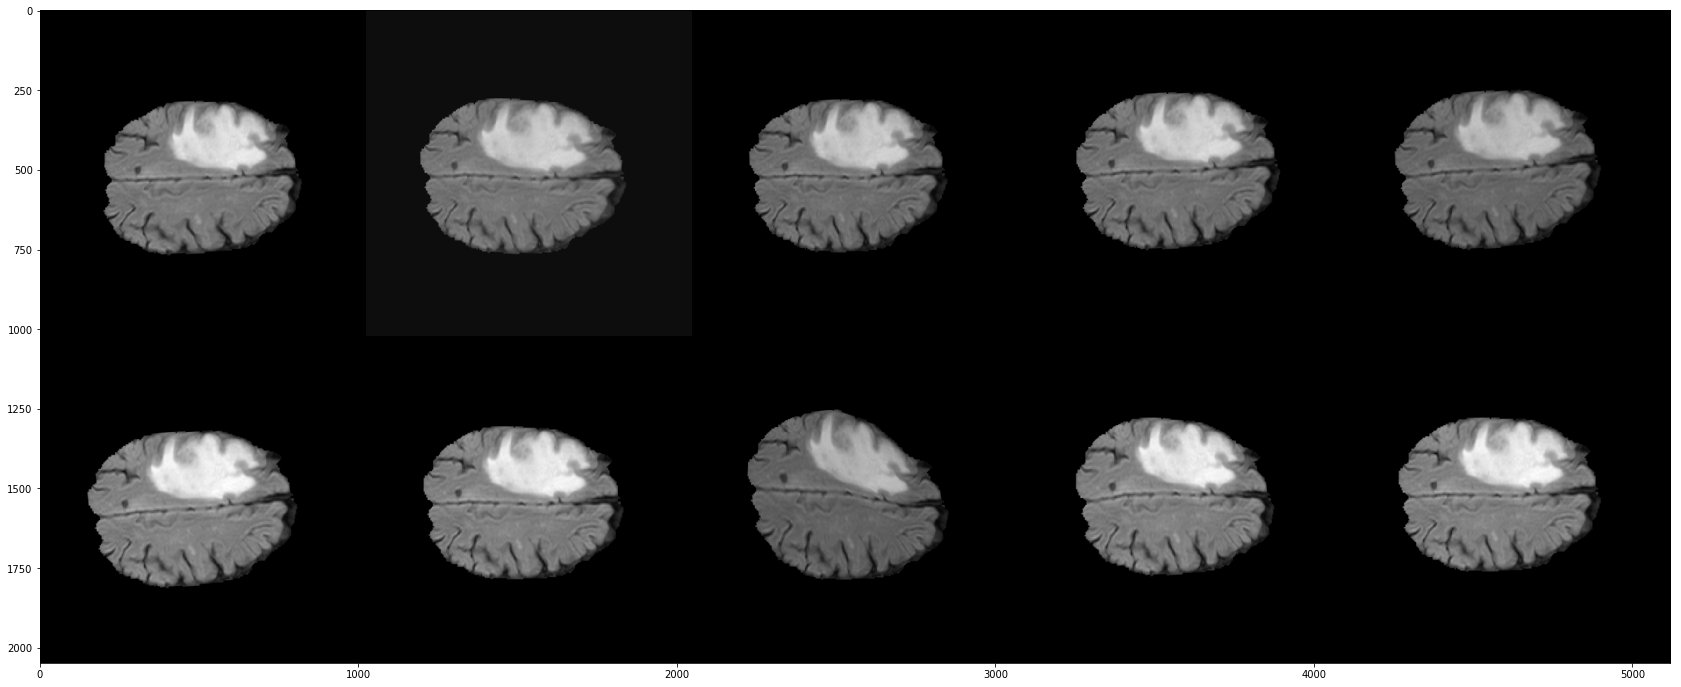

In [21]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.04), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.03, 0.03), "y": (-0.05, 0.05)},
            rotate=(-5, 5),
            shear=(-3, 3),
        ),
        iaa.PiecewiseAffine(scale=(0.002, 0.03)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.85, 1.15)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.12)),
        iaa.Sharpen(alpha=(0.0, 0.12)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [22]:
'''augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])'''

'augmentation = iaa.SomeOf((0, 1), [\n    iaa.Fliplr(0.5),\n    iaa.Affine(\n        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},\n        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},\n        rotate=(-25, 25),\n        shear=(-8, 8)\n    ),\n    iaa.Multiply((0.9, 1.1))\n])'

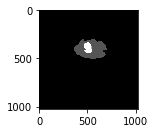

In [23]:
label1 = nib.load(image_fp.replace('imagesTr','labelsTr')).get_fdata()
label = cv2.resize(label1, None, fx=4.267, fy=4.267, interpolation=cv2.INTER_AREA)
plt.subplot(1, 3, 3)
plt.imshow(label[:,:,100],cmap='gray')

In [24]:
ROOT_DIR = '/mnt/serverhdd1/jaehyub/project'
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=500,
            layers='all',
       augmentation=augmentation) 

In [39]:
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

#model_path = sorted(fps)[-1]
model_path = '/mnt/serverhdd1/jaehyub/project/braintumour20190630T1107/mask_rcnn_braintumour_0498.h5'
print('Found model {}'.format(model_path))

Found model /mnt/serverhdd1/jaehyub/project/braintumour20190630T1107/mask_rcnn_braintumour_0498.h5


In [40]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mnt/serverhdd1/jaehyub/project/braintumour20190630T1107/mask_rcnn_braintumour_0498.h5
Re-starting from epoch 498


In [41]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(128, 128, 3)

*** No instances to display *** 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


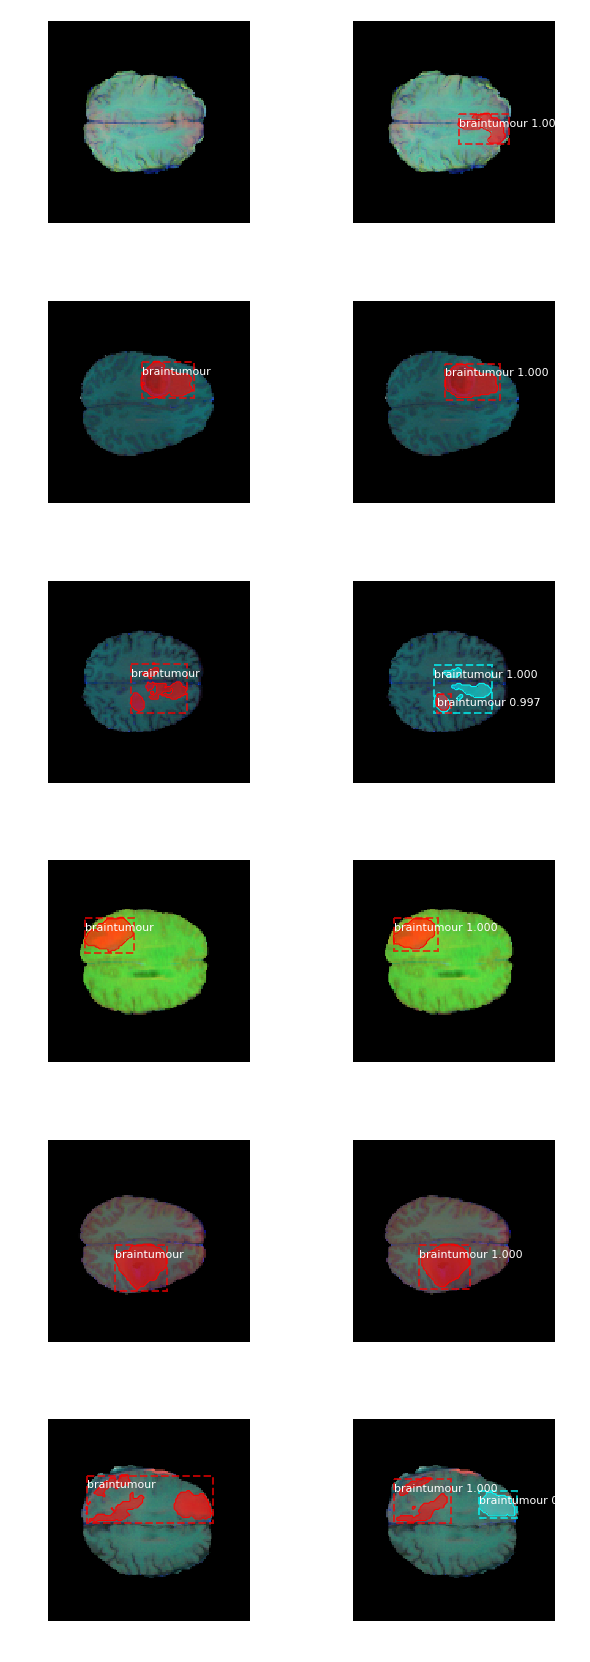

In [44]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config,image_id, use_mini_mask=False)
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'],ax=fig.axes[-1])
    

In [ ]:
visualize.display_weight_stats(model)

In [34]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)